In [1]:
import pandas as pd
import numpy as np
print("✅ Kernel & Library Berjalan Normal!")


✅ Kernel & Library Berjalan Normal!


In [2]:
pip install numpy pandas matplotlib pmdarima statsmodels scikit-learn openpyxl


  Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl.metadata (11 kB)
Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl (8.1 MB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 14.3 MB/s  0:00:00

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   -------------------------- ------------- 4/6 [conto

In [3]:
import pandas as pd

# 1️⃣ Baca data
df = pd.read_excel("dummy_pengunjung_perpustakaan.xlsx", parse_dates=['Tanggal'])

# 2️⃣ Hapus duplikat timestamp
df = df.drop_duplicates(subset=['Tanggal'])

# 3️⃣ Pastikan kolom Jumlah_Pengunjung bertipe angka
df['Jumlah_Pengunjung'] = pd.to_numeric(df['Jumlah_Pengunjung'], errors='coerce')

# 4️⃣ Buat kolom tanggal saja (tanpa jam)
df['Tanggal_Harian'] = df['Tanggal'].dt.date

# 5️⃣ Group by per hari → jika ada lebih dari 1 record per hari, dijumlahkan
df_daily = df.groupby('Tanggal_Harian')['Jumlah_Pengunjung'].sum()

# 6️⃣ Ubah index ke datetime
df_daily.index = pd.to_datetime(df_daily.index)

# 7️⃣ Resample menjadi harian, hari tanpa data → 0
df_daily = df_daily.resample('D').sum().fillna(0)

print("Hasil data harian yang sudah bersih:")
display(df_daily.head(10))
display(df_daily.tail(10))


Hasil data harian yang sudah bersih:


Tanggal_Harian
2025-07-25     73
2025-07-26      0
2025-07-27      0
2025-07-28    107
2025-07-29      0
2025-07-30    233
2025-07-31    144
2025-08-01      0
2025-08-02      0
2025-08-03      0
Freq: D, Name: Jumlah_Pengunjung, dtype: int64

Tanggal_Harian
2025-11-04    532
2025-11-05    474
2025-11-06    550
2025-11-07    489
2025-11-08    111
2025-11-09      0
2025-11-10    536
2025-11-11    512
2025-11-12    465
2025-11-13    630
Freq: D, Name: Jumlah_Pengunjung, dtype: int64

✔ Index berhasil dibuat: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

📅 Contoh data setelah resample & cleaning:


,Jumlah_Pengunjung
Tanggal,
2025-07-25,73
2025-07-26,40
2025-07-27,40
2025-07-28,107
2025-07-29,40
2025-07-30,233
2025-07-31,144
2025-08-01,40
2025-08-02,40


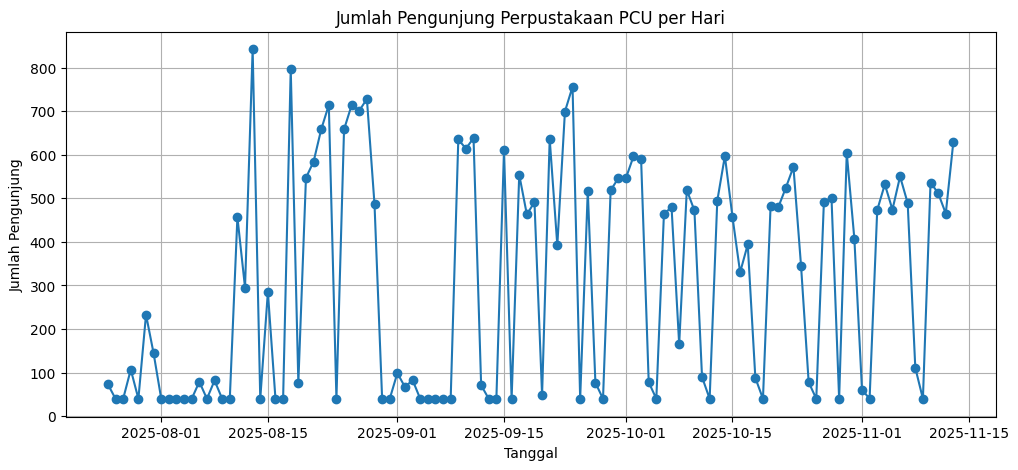

📊 Data Training = 89, Data Testing = 23
📦 Memuat model SARIMA tersimpan...


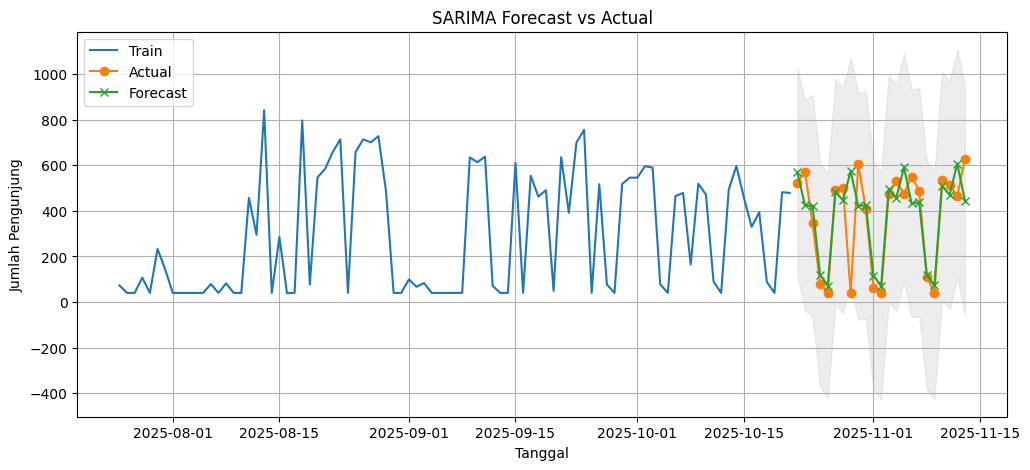

📉 RMSE: 140.328
📈 MAPE: 86.04%

🔮 Forecast 6 Hari Ke Depan:


,Forecast,Lower_CI,Upper_CI
2025-11-14,570,116,1025
2025-11-15,426,-36,887
2025-11-16,420,-68,908
2025-11-17,119,-372,610
2025-11-18,72,-421,565
2025-11-19,484,-9,978


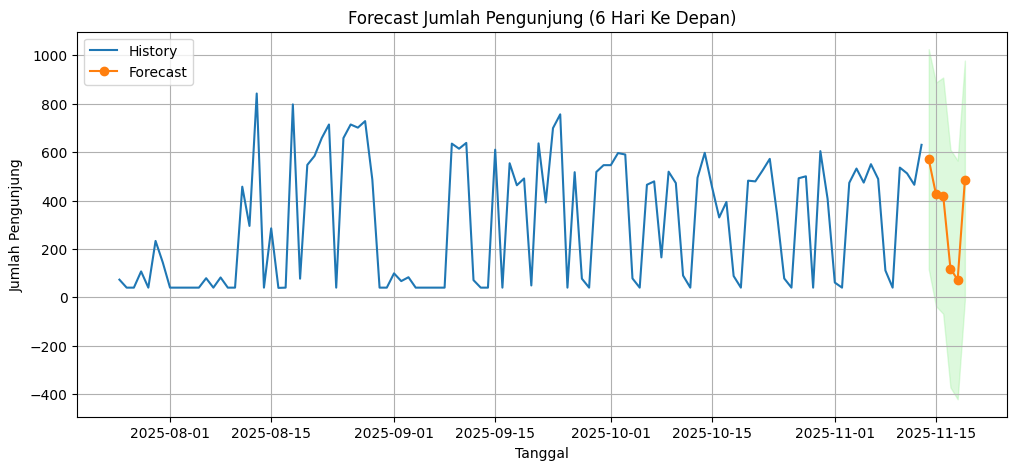


✅ Selesai tanpa error!


In [21]:
# ================================================================
# 📗 SARIMA Forecasting - Proyek Sistem Informasi Manufaktur (SIMF)
# ================================================================

# ------------------------------------------------
# 1️⃣ IMPORT LIBRARY
# ------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import joblib
import math
import os
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------
# 2️⃣ LOAD DATASET + CLEANING (FINAL FIX)
# ------------------------------------------------
excel_filename = "dummy_pengunjung_perpustakaan.xlsx"

# Baca file
data = pd.read_excel(excel_filename)

# Pastikan kolom Tanggal ada
if "Tanggal" not in data.columns:
    raise ValueError("Kolom 'Tanggal' tidak ditemukan di file Excel!")

# Convert ke datetime
data['Tanggal'] = pd.to_datetime(data['Tanggal'], errors='coerce')

# Hapus baris tanpa tanggal valid
data = data.dropna(subset=['Tanggal'])

# Set index ke tanggal
data = data.set_index('Tanggal')

print("✔ Index berhasil dibuat:", type(data.index))

# ------------------------------------------------
# 3️⃣ RESAMPLE KE HARIAN + ISI HARI KOSONG DENGAN 40
# ------------------------------------------------
data_daily = data.resample('D').sum()

# Isi missing values dengan jumlah staff (40 orang)
data_daily['Jumlah_Pengunjung'] = (
    data_daily['Jumlah_Pengunjung']
    .replace(0, 40)     # ubah 0 → 40
    .fillna(40)         # antisipasi NaN
    .astype(int)
)


print("\n📅 Contoh data setelah resample & cleaning:")
display(data_daily.head(10))

# Gunakan data_daily sebagai data final
data = data_daily

# ------------------------------------------------
# 4️⃣ VISUALISASI DATA
# ------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Jumlah_Pengunjung'], marker='o')
plt.title("Jumlah Pengunjung Perpustakaan PCU per Hari")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pengunjung")
plt.grid(True)
plt.show()

# ------------------------------------------------
# 5️⃣ TRAIN–TEST SPLIT (80% TRAIN)
# ------------------------------------------------
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

print(f"📊 Data Training = {len(train)}, Data Testing = {len(test)}")

# ------------------------------------------------
# 6️⃣ FUNGSI TRAIN & LOAD SARIMA
# ------------------------------------------------
model_path = "sarima_model.pkl"

def train_and_save_model(train_data):
    print("\n🔍 Mencari parameter terbaik dengan Auto ARIMA...")
    
    model_auto = auto_arima(
        train_data,
        seasonal=True,
        m=7,               # musiman mingguan (7 hari)
        stepwise=True,
        trace=True,
        suppress_warnings=True
    )

    print("\n📌 Parameter Optimal:")
    print(model_auto.summary())

    order = model_auto.order
    seasonal_order = model_auto.seasonal_order
    print(f"\nMenggunakan SARIMA{order}x{seasonal_order}")

    # Train SARIMA
    print("\n🏋️‍♂️ Melatih model SARIMA...")
    sarima_model = SARIMAX(
        train_data,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarima_result = sarima_model.fit(disp=False)

    # Simpan model
    joblib.dump({
        "model": sarima_result,
        "order": order,
        "seasonal_order": seasonal_order,
        "last_train_date": train_data.index[-1]
    }, model_path)

    print(f"💾 Model disimpan di: {model_path}")
    return sarima_result

def load_or_retrain(train_data):
    if os.path.exists(model_path):
        saved = joblib.load(model_path)
        saved_date = saved["last_train_date"]

        if train_data.index[-1] > saved_date:
            print("🔁 Data baru ditemukan → retraining...")
            return train_and_save_model(train_data)
        else:
            print("📦 Memuat model SARIMA tersimpan...")
            return saved["model"]
    else:
        print("🚀 Tidak ada model → training baru...")
        return train_and_save_model(train_data)

# Load/train model
sarima_result = load_or_retrain(train)

# ------------------------------------------------
# 7️⃣ FORECAST & VISUALISASI
# ------------------------------------------------
forecast = sarima_result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12,5))
plt.plot(train.index, train['Jumlah_Pengunjung'], label="Train")
plt.plot(test.index, test['Jumlah_Pengunjung'], label="Actual", marker='o')
plt.plot(test.index, forecast_mean, label="Forecast", marker='x')
plt.fill_between(test.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='lightgray', alpha=0.4)
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pengunjung")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------
# 8️⃣ EVALUASI MODEL
# ------------------------------------------------
rmse = math.sqrt(mean_squared_error(test, forecast_mean))
mape = np.mean(np.abs((test['Jumlah_Pengunjung'] - forecast_mean) / test['Jumlah_Pengunjung'])) * 100

print(f"📉 RMSE: {rmse:.3f}")
print(f"📈 MAPE: {mape:.2f}%")

# ------------------------------------------------
# 9️⃣ FORECAST 6 HARI KE DEPAN
# ------------------------------------------------
next_forecast = sarima_result.get_forecast(steps=6)
future_mean = next_forecast.predicted_mean
future_ci = next_forecast.conf_int()

future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=6)

forecast_table = pd.DataFrame({
    "Forecast": np.round(future_mean.values, 0).astype(int),
    "Lower_CI": np.round(future_ci.iloc[:,0].values, 0).astype(int),
    "Upper_CI": np.round(future_ci.iloc[:,1].values, 0).astype(int),
}, index=future_dates)

print("\n🔮 Forecast 6 Hari Ke Depan:")
display(forecast_table)

plt.figure(figsize=(12,5))
plt.plot(data.index, data['Jumlah_Pengunjung'], label="History")
plt.plot(forecast_table.index, forecast_table["Forecast"], marker='o', label="Forecast")
plt.fill_between(forecast_table.index, forecast_table["Lower_CI"], forecast_table["Upper_CI"],
                 color='lightgreen', alpha=0.3)
plt.title("Forecast Jumlah Pengunjung (6 Hari Ke Depan)")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pengunjung")
plt.legend()
plt.grid(True)
plt.show()

print("\n✅ Selesai tanpa error!")



🔮 Forecast 6 Hari ke Depan:


,Forecast_Jumlah_Pengunjung,Batas_Bawah,Batas_Atas
Tanggal,,,
2025-11-14,570,116,1025
2025-11-15,426,-36,887
2025-11-16,420,-68,908
2025-11-17,119,-372,610
2025-11-18,72,-421,565
2025-11-19,484,-9,978


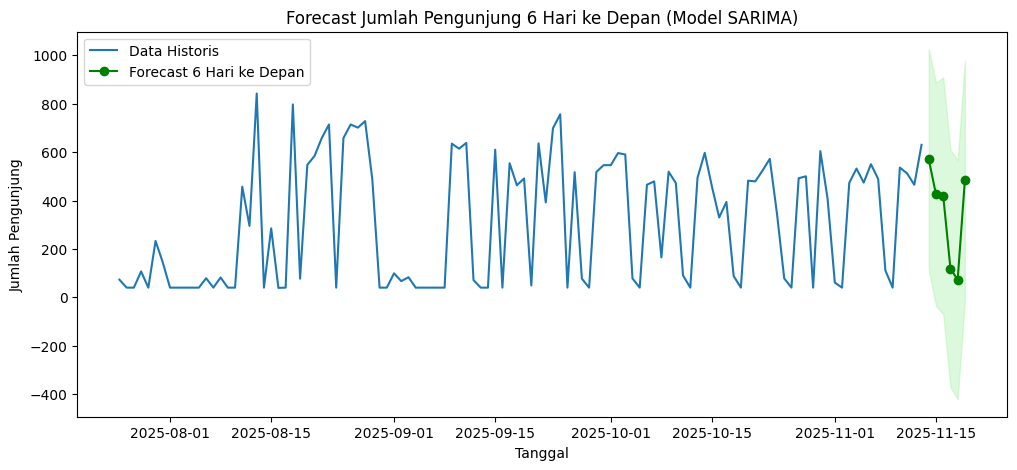

✅ Analisis Forecasting SARIMA selesai dengan sukses!


In [22]:

# ------------------------------------------------
# 8️⃣ FORECAST 6 PERIODE KE DEPAN
# ------------------------------------------------
forecast_next = sarima_result.get_forecast(steps=6)
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=6)
forecast_next_mean = forecast_next.predicted_mean
forecast_next_ci = forecast_next.conf_int()

forecast_table = pd.DataFrame({
    'Tanggal': future_dates,
    'Forecast_Jumlah_Pengunjung': np.round(forecast_next_mean.values, 0).astype(int),
    'Batas_Bawah': np.round(forecast_next_ci.iloc[:, 0].values, 0).astype(int),
    'Batas_Atas': np.round(forecast_next_ci.iloc[:, 1].values, 0).astype(int)
}).set_index('Tanggal')

print("\n🔮 Forecast 6 Hari ke Depan:")
display(forecast_table)

plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Jumlah_Pengunjung'], label='Data Historis')
plt.plot(forecast_table.index, forecast_table['Forecast_Jumlah_Pengunjung'],
         label='Forecast 6 Hari ke Depan', marker='o', color='green')
plt.fill_between(forecast_table.index, forecast_table['Batas_Bawah'],
                 forecast_table['Batas_Atas'], color='lightgreen', alpha=0.3)
plt.title("Forecast Jumlah Pengunjung 6 Hari ke Depan (Model SARIMA)")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pengunjung")
plt.legend()
plt.show()

print("✅ Analisis Forecasting SARIMA selesai dengan sukses!")
